# Feature Space Compatibility Analysis

**Overview:** This notebook helps you assess whether your user data is compatible with a trained model by analyzing how well it fits within the training data's feature space.

## What This Analysis Does

1. **Feature Distribution Analysis**: Compares individual feature distributions between your data and training data
2. **UMAP Visualization**: Projects both datasets into 2D space to visualize overall feature space relationships  
3. **Coverage Analysis**: Quantifies what percentage of your data falls within the "normal" range of the training data

## Instructions

1. Generate features. 
    Follow instructions to run ArtiCull classify using the --extract-features-only flag: https://articull.readthedocs.io/en/latest/usage.html
    
    Note that a representative subset of variants is sufficient for this analysis, and you don't need to extract features for all samples or all variants in a sample. 

2. Update file path for `USER_FEATURES_DIR` in the first code cell to the directory containing extracted features. 

3. Run all cells


# Configuration and Setup

Update the following cell with the path to a directory containing the extracted featues for your data. You don't need to

In [ ]:
# Update path to point to your data
USER_FEATURES_DIR = "/update/path/to/extracted/features/"          # Directory containing user feature .tsv files

import os
if not os.path.isdir(USER_FEATURES_DIR): raise ValueError("Update USER_FEATURES_DIR to the directory containing extracted features on your data")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

TRAINING_DATA_PICKLE = "evaluate_model_transferability/test_feature_space_data.pkl"  # Precomputed training data

In [11]:
import pickle
from evaluate_model_transferability.test_feature_space import load_tsvs

# Load precomputed training data
with open(TRAINING_DATA_PICKLE, 'rb') as f:
    training_data_info = pickle.load(f)

training_merged = training_data_info['training_merged']
feature_cols = training_data_info['feature_cols']

print(f"Loaded precomputed training data: {training_merged.shape}")
print(f"Feature columns: {len(feature_cols)}")

# Load user data
user_data = load_tsvs(USER_FEATURES_DIR)
print(f"Loaded {len(user_data)} rows of user features from {len(glob.glob(os.path.join(USER_FEATURES_DIR, '*.tsv')))} files")

Loaded precomputed training data: (35000, 25)
Feature columns: 15
Loaded 19174 rows of user features from 1 files


# Feature Distribution Analysis

**What to expect:** Your user data (gray) should look like it could plausibly be a mixture of the training data distributions. The user data doesn't need to match any single training category exactly, but should fall within the overall range and patterns of the training data.

**Good signs:**
- User data distributions overlap with training data ranges
- User data appears to be a reasonable mixture of training passing/artifact/unlabeled patterns

**Potential concerns:**
- User data falls completely outside training data ranges
- User data has dramatically different distribution shapes 
- User data is systematically shifted from all training categories

Remember: Different proportions of artifacts vs. passing variants in your data compared to training is normal and expected.

Data for plotting:
  Training passing: 7475
  Training artifact: 2587
  Training unlabeled: 24938
  User data: 19174


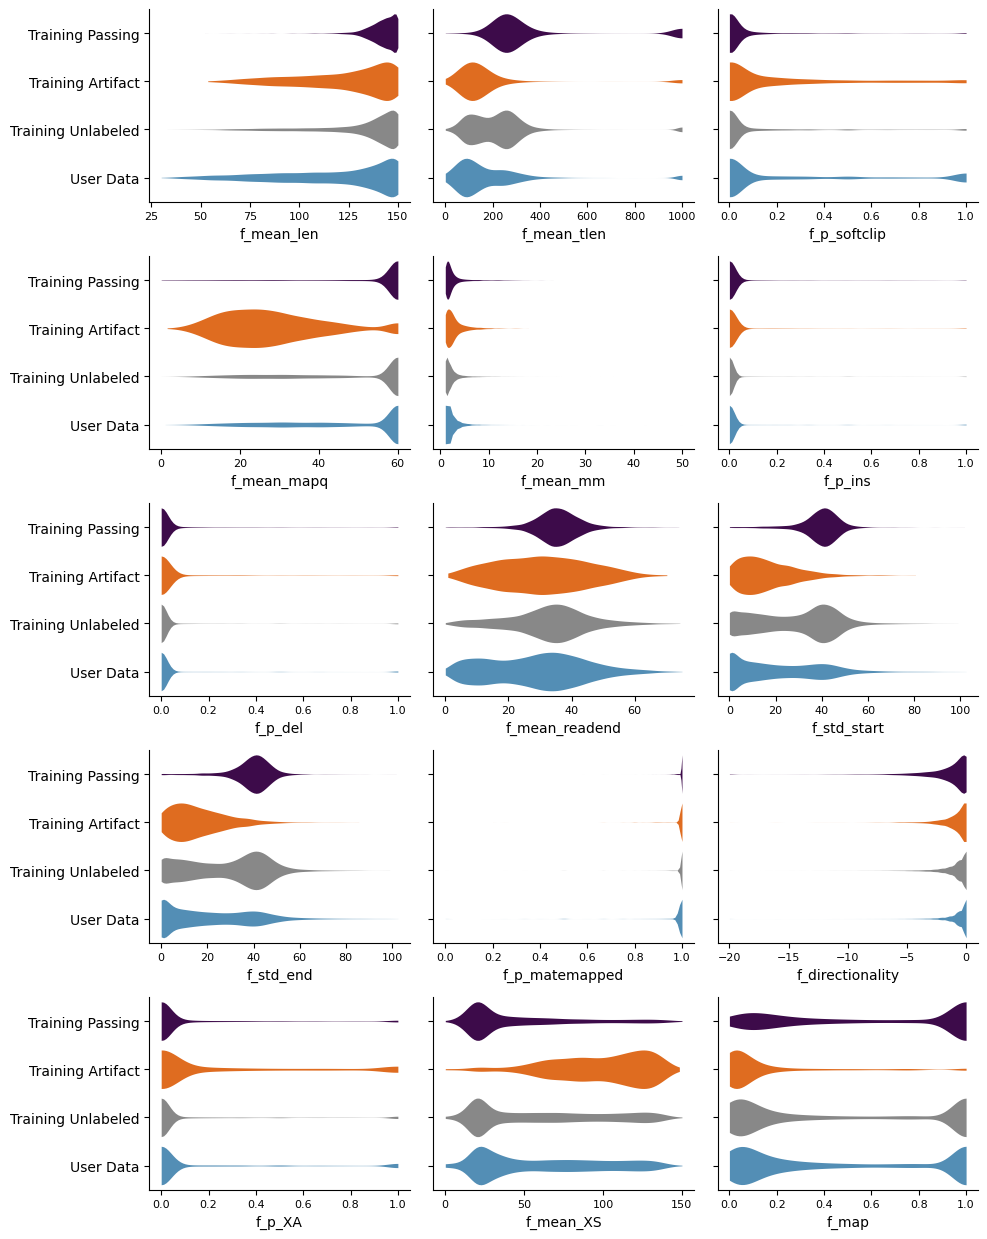

In [12]:
from evaluate_model_transferability.test_feature_space  import plot_feature_distributions

plot_feature_distributions(training_merged, user_data, feature_cols=feature_cols)


# UMAP Feature Space Visualization

**Purpose:** This visualizes how the user data projects onto the feature space defined by the training data. Each plot highlights one category to make patterns easier to see.

**Good signs:**
- User data points fall within or near the training data clusters
- User data appears to be a mixture spanning across training categories
- No large isolated clusters of user data far from all training categories

**Potential concerns:**
- User data forms tight clusters completely separate from training data
- User data systematically shifted to one extreme edge of the feature space
- Large gaps between user data and all training categories

The key question: Does the user data look like it could plausibly be a mixture of the training categories, or does it appear to come from a completely different feature distribution?

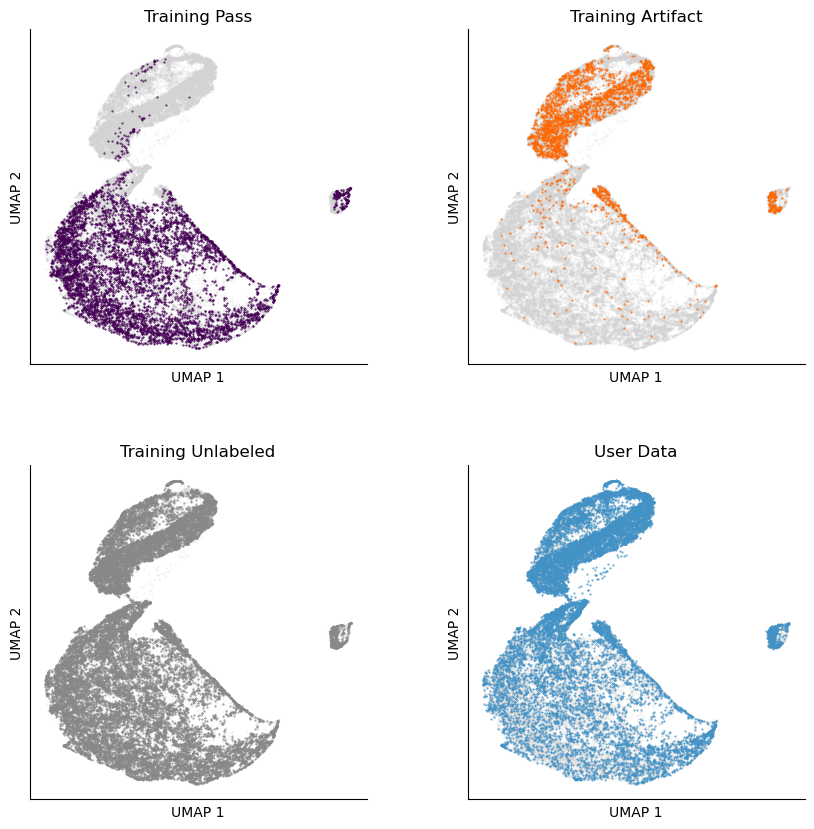

In [13]:
# Compute and plot UMAP embeddings using precomputed reducer
from evaluate_model_transferability.test_feature_space import compute_umap_results, plot_umap_distributions

umap_results = compute_umap_results(user_data, feature_cols, training_data_info)
plot_umap_distributions(umap_results)

### Feature Coverage

**Coverage metric:**  
This metric evaluates how well the user data is represented within the training data's feature space. For each user point, it computes the distance to its nearest training point. For comparison, it also computes the distance between each training point and its nearest training neighbor (excluding itself). It then reports the **proportion of user points** whose nearest-neighbor distance is **within the 99th percentile** of the training-to-training distances.

**What to look for:**  
The user distance distribution should broadly overlap with the training distance distribution. A small tail beyond the threshold is expected. However, a **large shift**, **bimodal distribution**, or **high proportion of outliers** may indicate that the user data lies partially or wholly outside the training feature space, and retraining may be necessary.


Coverage: 97.8% of user data within training feature space


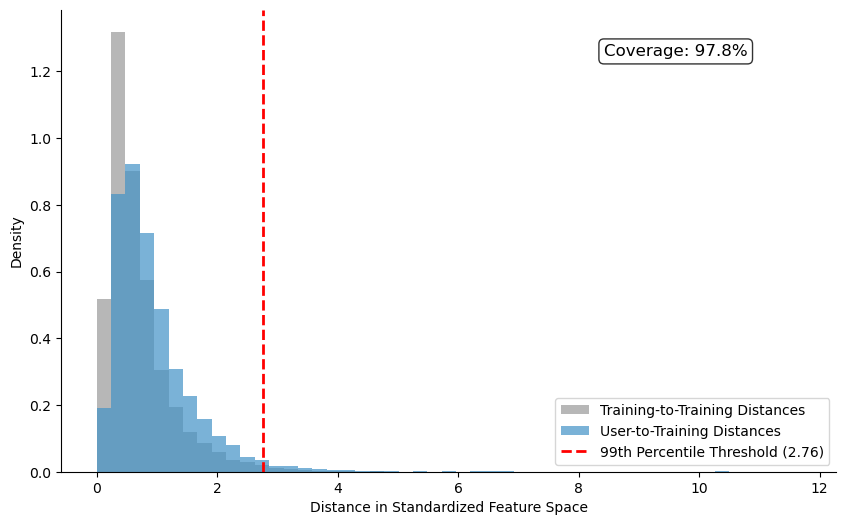

In [14]:
# Compute coverage metrics and plot distance distributions
from evaluate_model_transferability.test_feature_space import run_coverage_analysis

coverage_results = run_coverage_analysis(user_data, feature_cols, training_data_info)

# Uncovered Points Analysis

**Purpose:** If some user data falls outside the training feature space, this analysis helps identify which features are driving those differences.

This analysis will only run if there are uncovered points from the coverage analysis above. A small amount (1%) of uncovered points is expected even if user data is drawn from the same distribution as the training, as the threshold is the 99th percentile 

Uncovered points: 364 (2.2%)

Feature distributions: Uncovered user data vs Training data
Data for plotting:
  Training passing: 7475
  Training artifact: 2587
  Training unlabeled: 24938
  User data: 364


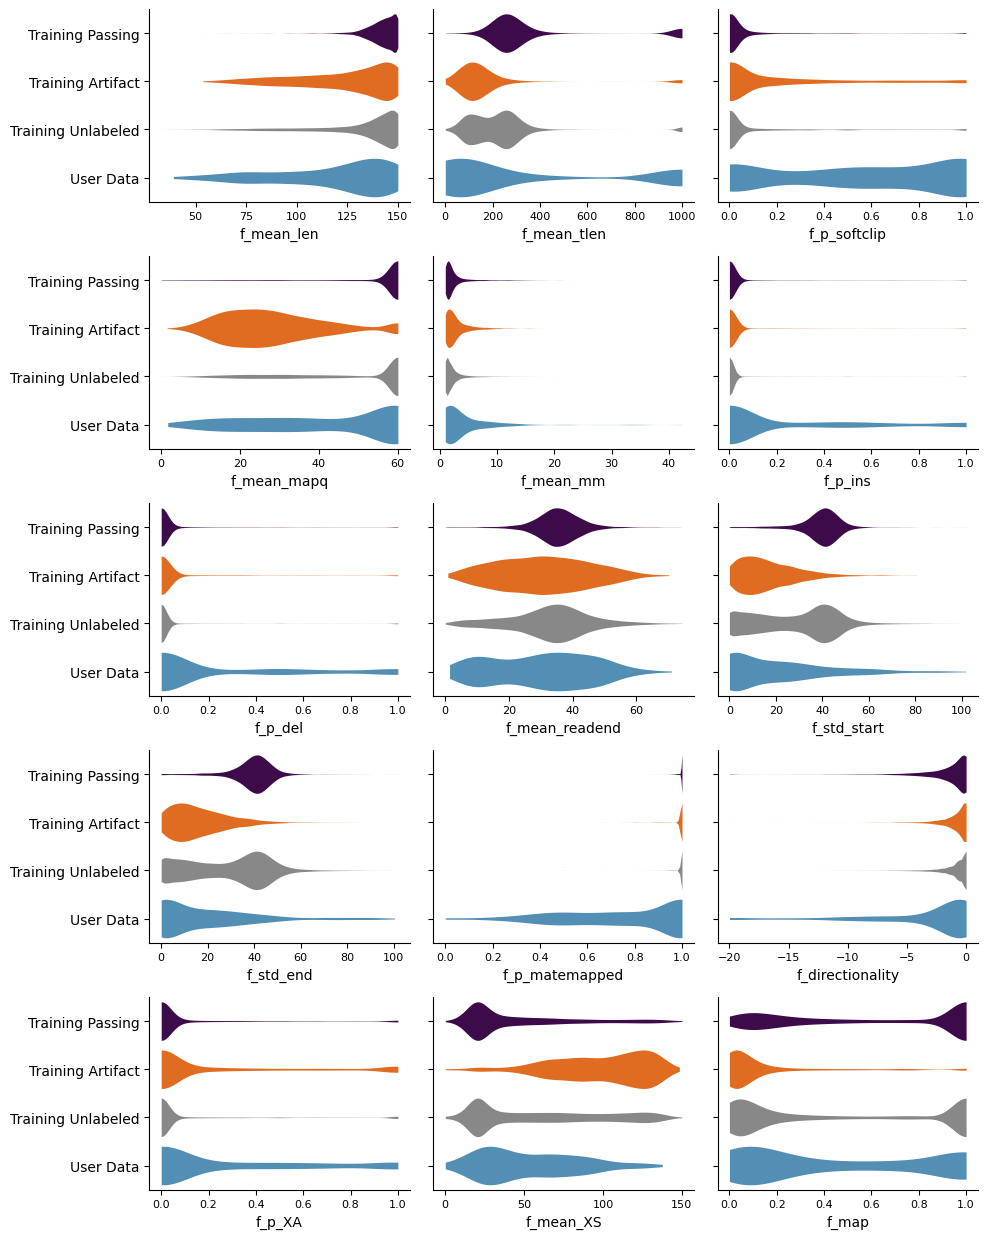

In [15]:
# Analyze uncovered points to understand what drives outliers
from evaluate_model_transferability.test_feature_space  import analyze_uncovered_points

analyze_uncovered_points(user_data, coverage_results, training_merged, feature_cols)